共读取到 2 张图像，即将开始处理
4号图噪音占比为： 0.00762939453125 %
65号图噪音占比为： 0.0518798828125 %


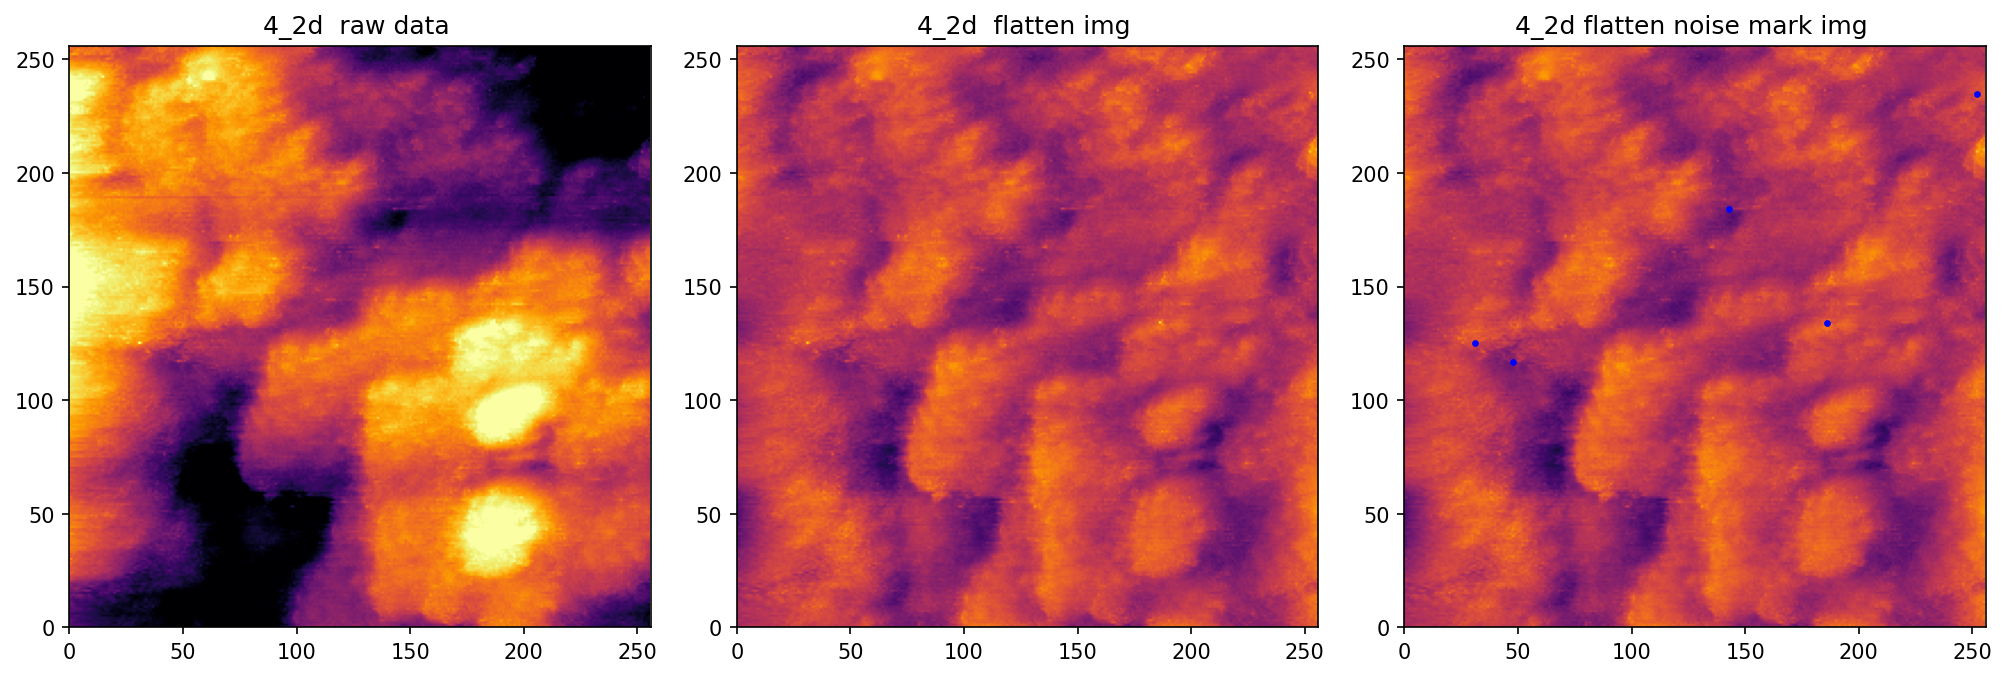

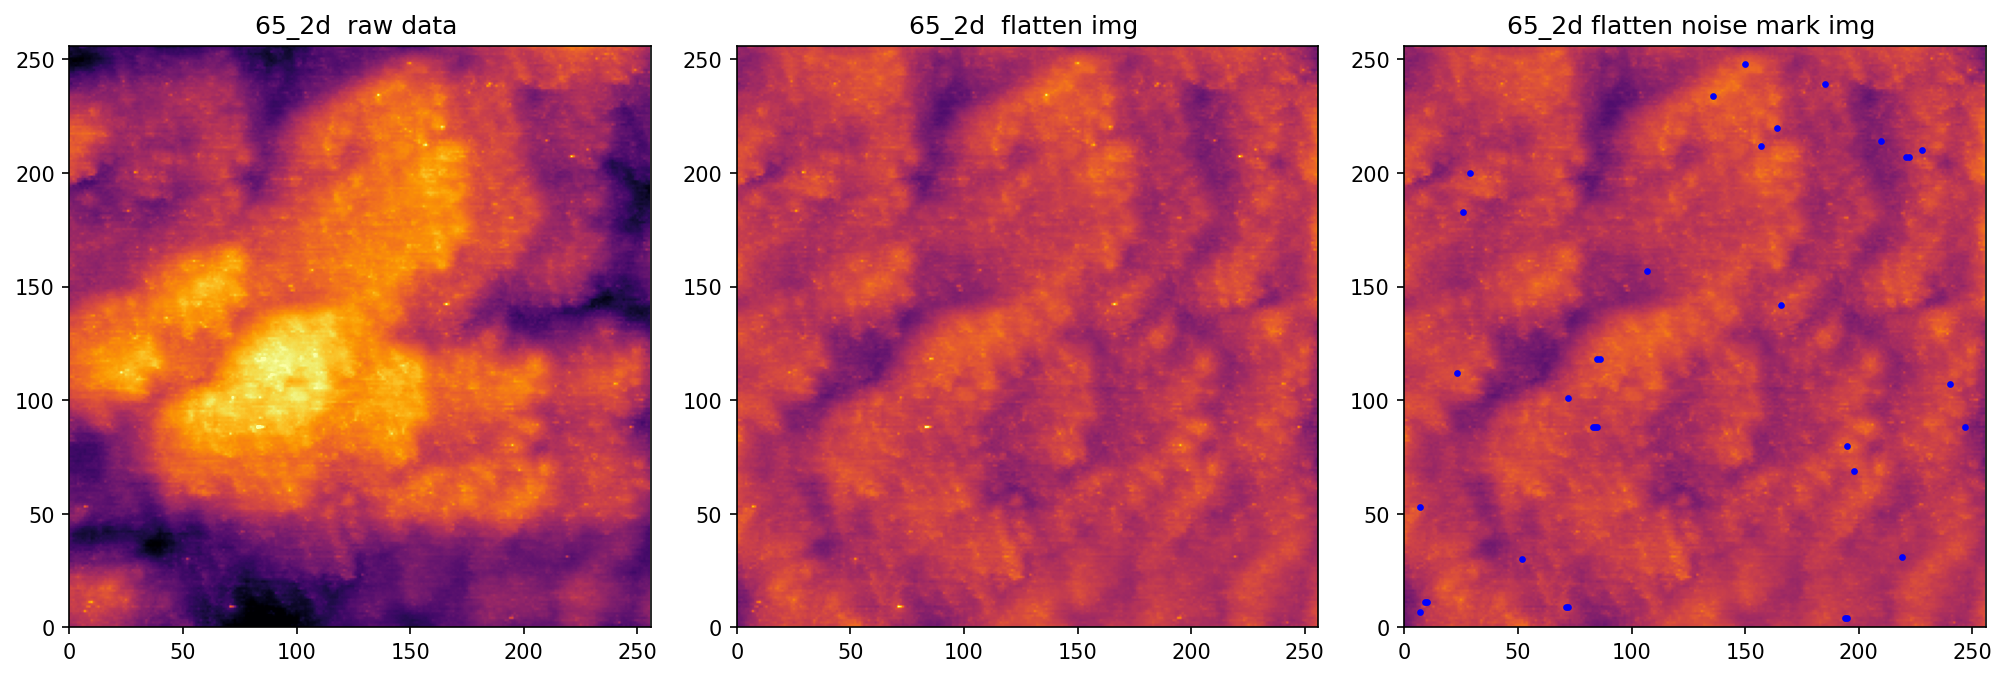

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import  glob
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

def show_3d_noise(name,img,noise_matrix):
    
    peak=[]
    peak_class=[]
    for i in range(noise_matrix.shape[1]):
        peak.append(img[noise_matrix[0][i]][noise_matrix[1][i]])
        peak_class.append('red')
    peak=np.array(peak)

    x_lines=[]
    y_lines=[]
    nomal_class=[]
    z_lines=[]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_lines.append(i)
            y_lines.append(j)
            nomal_class.append('blue')
            z_lines.append(img[i][j])
    x_lines=np.array(x_lines)
    y_lines=np.array(y_lines)
    
    x, y = np.linspace(0, 255, img.shape[0]), np.linspace(0, 255, img.shape[1])
    z_lines=np.array(z_lines)

    
    x_lines=np.concatenate((x_lines,noise_matrix[0]))
    y_lines=np.concatenate((y_lines,noise_matrix[1]))
    z_lines=np.concatenate((z_lines,peak))
    classes=np.concatenate((nomal_class,peak_class))

    
    
    fig = go.Figure(data=[go.Surface(z=img, x=x, y=y)])
    
    fig.add_trace(go.Scatter3d(
        x=noise_matrix[1],  # 设置3个不同的坐标数据
        y=noise_matrix[0], 
        z=peak,
        mode='markers',
        marker=dict(
        size=5,
        color='blue',
        opacity=0.8 ,showscale=True)
    ))
    
    fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=4, range=[0,255],),
                    yaxis = dict(nticks=4, range=[0,255],),
                    zaxis = dict(nticks=4, range=[-1.5,1.5],),),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    
    fig.write_html(name+"_scatter_surface_3d.html")
    fig.show()
    
def show_3d(name,img):

    x_lines=[]
    y_lines=[]
    nomal_class=[]
    z_lines=[]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x_lines.append(i)
            y_lines.append(j)
            nomal_class.append('blue')
            z_lines.append(img[i][j])
    x_lines=np.array(x_lines)
    y_lines=np.array(y_lines)
    
    x, y = np.linspace(0, 255, img.shape[0]), np.linspace(0, 255, img.shape[1])
    z_lines=np.array(z_lines)
    
    fig = go.Figure(data=[go.Surface(z=img, x=x, y=y)])
    
    fig.update_layout(
                scene = dict(
                    xaxis = dict(nticks=4, range=[0,255],),
                    yaxis = dict(nticks=4, range=[0,255],),
                    zaxis = dict(nticks=4, range=[-1.5,1.5],),),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
    
    fig.write_html(name+"_surface_3d.html")
    fig.show()

def flatten(img,degree):
    x_axis=[]
    y_pred=[]
    for x in range(256):
        x_axis.append(x)

    for i in range(256):#取每一行做多项式回归拟合
        y_train=img[i]#取第i行
        x_train=x_axis
        x_train=np.array(x_train).reshape(256,1)
        y_train=y_train.reshape(256,1)
        quadratic_featurizer = PolynomialFeatures(degree)
        X_train_quadratic = quadratic_featurizer.fit_transform(x_train)
        regressor_quadratic = LinearRegression()
        regressor_quadratic.fit(X_train_quadratic,y_train)
        Ypred = regressor_quadratic.predict(X_train_quadratic)  # 对测试结果进行预测
        y_pred.append(Ypred)

    linear_img=np.array(y_pred)
    linear_img=linear_img.reshape(256,256)
    flatten_img=img-linear_img#flatten图像就是原始图像减去拟合图像
    return linear_img,flatten_img


def show_highlight_noise(file_name,rawdata,flatten,noise_matrix):
    row = 1
    col = 3
    vmin=-1
    vmax=1
    # cmap = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
    fig = plt.figure(figsize=(4.5*col,4.5*row), dpi=150, facecolor='white')
    gs = fig.add_gridspec(row,col)
    

    ax  = fig.add_subplot(gs[0])
    ax.imshow(rawdata, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0,256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+" raw data ")
    
    
    
    ax  = fig.add_subplot(gs[1])
    ax.imshow(flatten, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0, 256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+" flatten img ")
    
    ax  = fig.add_subplot(gs[2])
    plt.scatter(x=noise_matrix[1], y=noise_matrix[0],s=5,c='b')
    ax.imshow(flatten, vmin=vmin, vmax=vmax, cmap='inferno')
    ax.set_ylim(0, 256)
    ax.set_xlim(0, 256)
    ax.set_title(file_name+"flatten noise mark img ")
    

    fig.tight_layout()
    fig.show()
    fig.savefig(file_name)

    

def compute_local_min(local_patch,radius):
    
    #边界上的值平均
    local_min=[]
    max_num=(np.array(local_patch).shape)[0]
    local_min.append(local_patch[0,:])
    local_min.append(local_patch[max_num-1,:])
    local_min.append(local_patch[:,0])
    local_min.append(local_patch[:,max_num-1])
    sum_num=(np.array(local_min).sum())-local_patch[0,0]-local_patch[0,max_num-1]-local_patch[max_num-1,0]-local_patch[max_num-1,max_num-1]
    local_min=sum_num/(4*(max_num-1))
    
    return local_min
    
def is_peak(local_patch,threshold,radius,topk):
    #假设就是极大值
    peak_point=topk
    for i in range(2*radius-1):
        for j in range(2*radius-1):
            if local_patch[i][j]>=local_patch[radius-1][radius-1]:
                if i!=(radius-1) or j!=(radius-1):#不是它本身
                    peak_point-=1#范围内有值比它大或者等于它，该点不是极大值
                    if peak_point==0:
                        return peak_point

    
    local_min=compute_local_min(local_patch,radius)
    if local_patch[radius-1][radius-1]-local_min<threshold:
        peak_point-=1#虽然是极大值，但是在阈值以内
        if peak_point==0:
            return peak_point
    else:
        return peak_point#周围的值都不如它大，

def get_noise_matrix_local(filename,threshold,radius,topk,img):
    
    x=[]
    y=[]
    img=np.array(img)
    length=(img.shape)[0]
    minimum=np.min(img)
    img_pad = np.pad(img,radius,'linear_ramp')
    for i in range(radius,length+radius):
        for j in range(radius,length+radius):
            local_patch=img_pad[i-radius+1:i+radius,j-radius+1:j+radius]
            if is_peak(local_patch,threshold,radius,topk):
                    x.append(i-radius)
                    y.append(j-radius)

    noise_matrix=list(zip(x,y))
    noise_num=(np.array(noise_matrix).shape)[0]
    print(filename+"号图噪音占比为：",(100*(noise_num)/(256**2)),"%")
    noise_matrix=np.swapaxes(noise_matrix, 0, 1)
    return noise_matrix

def Flatten_Mark_noise(data_path,
                       degree,
                       threshold,
                       radius,
                       topk,
                       show_data_2d,
                       show_data_3d):
    
    data_path+=(r'*.txt')
    data_path = glob.glob(data_path)
    img_names=[]
    imgs=[]
    for i in range(len(data_path)):
        img_name=data_path[i]
        img_name= img_name[img_name.rfind('0')+1:img_name.rfind('.s')]
        img_names.append(img_name)
        
        img=np.loadtxt(data_path[i])
        img = img.reshape(256, 256)
        imgs.append(img)
    img_names=np.array(img_names)
    imgs=np.array(imgs)

    print("共读取到",len(img_names),"张图像，即将开始处理")
    for i in range(len(img_names)):
        linear_img,flatten_img=flatten(imgs[i],degree)
        noise_matrix=get_noise_matrix_local(img_names[i],threshold,radius,topk,flatten_img)
        if show_data_2d:
            show_highlight_noise(img_names[i]+'_2d ',imgs[i],flatten_img,noise_matrix)
        if show_data_3d:
            show_3d(img_names[i]+'_3d',imgs[i])
            show_3d(img_names[i]+'_flatten_3d',flatten_img)
            show_3d_noise(img_names[i]+"_flatten_noise_3d",flatten_img,noise_matrix)
        

def main():
    degree=3 #多项式拟合最高次           默认使用3次多项式拟合
    threshold=0.35 #判断噪音点与周围一圈像素点平均值差值的阈值
    radius=2#判断噪音点的半径，算上中心点，如radius=2 就是只算了3x3像素的矩阵
    topk=3#噪音点不一定是本区域最大值，这里topk就是指噪音点可以是本区域的前k大的值
    show_data_2d=True #输出2d图像 包括原始图像 flatten图像 带噪声标记的flatten图像
    show_data_3d=False #输出3d图像 包括原始图像 flatten图像 带噪声标记的flatten图像 方便看flatten和噪声效果的
    data_path=r'img/'#ttxt文件放到当前目录下的img文件夹即可
    Flatten_Mark_noise(data_path,
                       degree,
                       threshold,
                       radius,
                       topk,
                       show_data_2d,
                       show_data_3d
                      )
    

if __name__ == '__main__':
    main()    